Tributec-AI — SEMANA 2: RISCO CAMBIAL COM API BACEN
Erro na API Bacen: Expecting value: line 1 column 1 (char 0). Usando dados simulados.

CÂMBIO USD/BRL (últimos 30 dias):
          data   cotacao
25  2025-11-08  5.669383
26  2025-11-09  5.618343
27  2025-11-10  5.638606
28  2025-11-11  5.633307
29  2025-11-12  5.658448


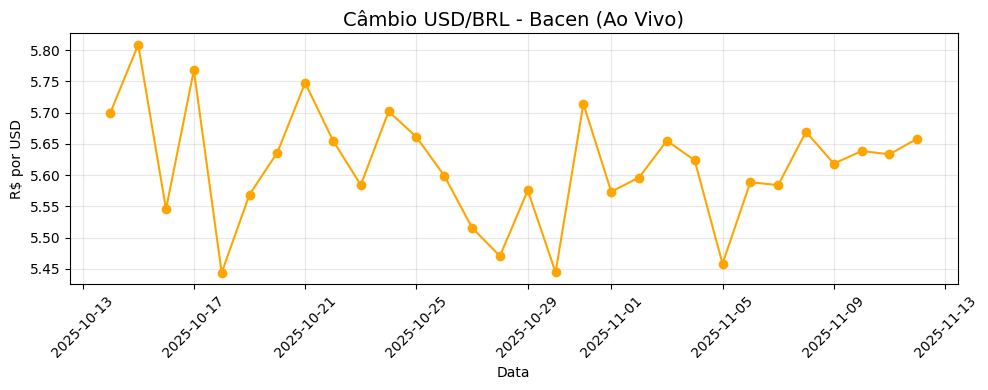


Parâmetros:
Câmbio médio: R$ 5.61
Volatilidade: 1.63%
Simulações: 10000

RISCO TRIBUTÁRIO (VaR):
VaR 95%: R$ 98,344 (5% chance de exceder)
VaR 99%: R$ 97,250 (1% chance de exceder)
ICMS médio: R$ 101,060


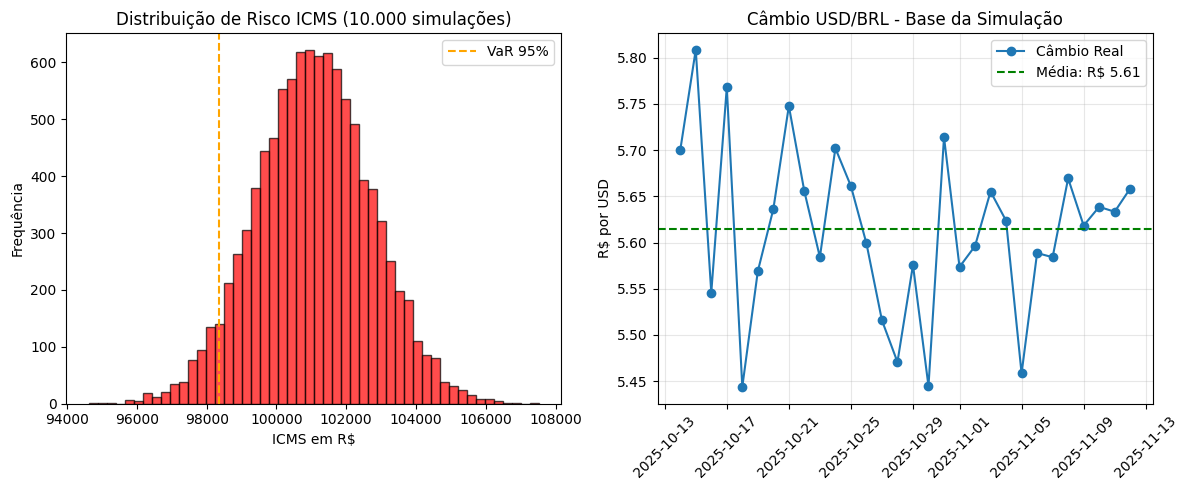


RESULTADOS SALVOS EM: data/risco_cambial.csv

PRÓXIMOS PASSOS:
1. Atualize cronograma.csv no Excel (Semana 2: CONCLUÍDO)
2. Commit no GitHub: git add . && git commit -m 'feat: Monte Carlo risco cambial' && git push
3. Assista: https://youtu.be/7y1x5r4b91w (Monte Carlo)


In [1]:
# ================================
# 02_monte_carlo_risco_cambial.ipynb
# TRIBUTEC AI — Semana 2
# Karlos Neves | 10-16/nov/2025
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta

print("Tributec-AI — SEMANA 2: RISCO CAMBIAL COM API BACEN")
print("=" * 60)

# === 1. API BACEN: CÂMBIO USD/BRL AO VIVO ===
def get_cambio_bacen():
    """Puxa câmbio real do Bacen (últimos 30 dias)"""
    base_url = "https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/odata/CotacaoDolarPeriodo"
    data_inicio = (datetime.now() - timedelta(days=30)).strftime('%m-%d-%Y')
    data_fim = datetime.now().strftime('%m-%d-%Y')
    params = {
        'dataInicial': data_inicio,
        'dataFinalCotacao': data_fim,
        '$format': 'json'
    }
    try:
        resp = requests.get(base_url, params=params)
        data = resp.json()['value']
        df_cambio = pd.DataFrame(data)
        df_cambio['data'] = pd.to_datetime(df_cambio['dataHoraCotacao']).dt.date
        df_cambio['cotacao'] = df_cambio['cotacaoVenda'].astype(float)
        return df_cambio[['data', 'cotacao']]
    except Exception as e:
        print(f"Erro na API Bacen: {e}. Usando dados simulados.")
        dates = pd.date_range(end=datetime.now(), periods=30)
        cotacao = np.random.normal(5.6, 0.1, 30)  # Simulação: média R$5,60, desvio 0,10
        return pd.DataFrame({'data': dates.date, 'cotacao': cotacao})

df_cambio = get_cambio_bacen()
print("\nCÂMBIO USD/BRL (últimos 30 dias):")
print(df_cambio.tail(5))

# Gráfico do câmbio
plt.figure(figsize=(10, 4))
plt.plot(df_cambio['data'], df_cambio['cotacao'], marker='o', color='orange')
plt.title('Câmbio USD/BRL - Bacen (Ao Vivo)', fontsize=14)
plt.ylabel('R$ por USD')
plt.xlabel('Data')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === 2. PARÂMETROS DA SIMULAÇÃO ===
cambio_medio = df_cambio['cotacao'].mean()  # Câmbio médio real
volatilidade = df_cambio['cotacao'].std() / cambio_medio  # Volatilidade real
num_simulacoes = 10000
valor_importacao_usd = 100000  # Exemplo: US$ 100k por operação
aliquota_icms_import = 0.18  # ICMS sobre importação

print(f"\nParâmetros:")
print(f"Câmbio médio: R$ {cambio_medio:.2f}")
print(f"Volatilidade: {volatilidade:.2%}")
print(f"Simulações: {num_simulacoes}")

# === 3. MONTE CARLO: SIMULAÇÃO DE RISCO ===
np.random.seed(42)  # Reprodutibilidade
cambios_simulados = np.random.normal(cambio_medio, volatilidade * cambio_medio, num_simulacoes)
valores_brl = valor_importacao_usd * cambios_simulados
icms_simulado = valores_brl * aliquota_icms_import

df_sim = pd.DataFrame({
    'cambio_simulado': cambios_simulados,
    'valor_brl': valores_brl,
    'icms_risco': icms_simulado
})

# === 4. VaR (Value at Risk) — Risco Tributário ===
var_95 = np.percentile(icms_simulado, 5)  # 5% pior cenário
var_99 = np.percentile(icms_simulado, 1)  # 1% pior cenário

print(f"\nRISCO TRIBUTÁRIO (VaR):")
print(f"VaR 95%: R$ {var_95:,.0f} (5% chance de exceder)")
print(f"VaR 99%: R$ {var_99:,.0f} (1% chance de exceder)")
print(f"ICMS médio: R$ {icms_simulado.mean():,.0f}")

# === 5. GRÁFICO DE DISTRIBUIÇÃO ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(icms_simulado, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.axvline(var_95, color='orange', linestyle='--', label='VaR 95%')
plt.title('Distribuição de Risco ICMS (10.000 simulações)')
plt.xlabel('ICMS em R$')
plt.ylabel('Frequência')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_cambio['data'], df_cambio['cotacao'], marker='o', label='Câmbio Real')
plt.axhline(cambio_medio, color='green', linestyle='--', label=f'Média: R$ {cambio_medio:.2f}')
plt.title('Câmbio USD/BRL - Base da Simulação')
plt.ylabel('R$ por USD')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === 6. SALVA RESULTADOS ===
df_sim.to_csv('../data/risco_cambial.csv', index=False)
print(f"\nRESULTADOS SALVOS EM: data/risco_cambial.csv")

# === 7. PRÓXIMOS PASSOS ===
print("\nPRÓXIMOS PASSOS:")
print("1. Atualize cronograma.csv no Excel (Semana 2: CONCLUÍDO)")
print("2. Commit no GitHub: git add . && git commit -m 'feat: Monte Carlo risco cambial' && git push")
print("3. Assista: https://youtu.be/7y1x5r4b91w (Monte Carlo)")